In [1]:
# Sel 1: Impor Pustaka Utama dan Pengaturan Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os

# Menambahkan path ke direktori 'backend/app/' agar bisa mengimpor modul dari 'algorithm'
# Asumsi notebook ini ada di 'TUBES_KDS/notebook/'
# dan modul GA ada di 'TUBES_KDS/backend/app/algorithm/'
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', 'backend', 'app')))

# Impor modul-modul dari package 'algorithm'
try:
    from algorithm.chromosome_setup import FEATURE_ORDER, FEATURE_DETAILS, initialize_chromosome, user_input_to_chromosome, NUM_FEATURES
    from algorithm.fitness import calculate_combined_fitness # Pastikan nama fungsi ini benar di fitness.py
    from algorithm.operators import tournament_selection, uniform_crossover, combined_mutation # Atau combined_crossover
    from algorithm.ga_core import GeneticAlgorithmFeatureSelection # Pastikan nama kelas ini benar
    print("INFO: Modul algoritma berhasil diimpor.")
except ImportError as e:
    print(f"ERROR: Gagal mengimpor modul algoritma: {e}")
    print("Pastikan struktur direktori, nama file, __init__.py, dan nama fungsi/kelas sudah benar.")
    # Definisikan fallback jika perlu agar notebook bisa lanjut (meski GA tidak akan jalan)
    FEATURE_ORDER = []
    FEATURE_DETAILS = {}
    NUM_FEATURES = 0
    GeneticAlgorithmEvolutionSimulator = None

# Pengaturan untuk tampilan plot
%matplotlib inline
sns.set(style="whitegrid")

INFO: Modul algoritma berhasil diimpor.


In [2]:
# Sel 2: Memuat Dataset Evolusi
# Sesuaikan path jika struktur direktori Anda berbeda.
# Asumsi dataset ada di 'TUBES_KDS/data/Evolution_DataSets.csv'
DATASET_PATH = os.path.abspath(os.path.join(os.getcwd(), '..', 'data', 'Evolution_DataSets.csv'))
evolution_df = None
data_load_error = None

try:
    print(f"Mencoba memuat dataset dari: {DATASET_PATH}")
    if not os.path.exists(DATASET_PATH):
        data_load_error = f"Dataset tidak ditemukan di path: {DATASET_PATH}."
        print(data_load_error)
    else:
        evolution_df = pd.read_csv(DATASET_PATH)
        # Basic cleaning
        LABEL_COL_IN_DATASET = 'Genus_&_Specie' # Sesuai diskusi sebelumnya
        evolution_df.dropna(subset=[LABEL_COL_IN_DATASET], inplace=True)
        # Anda bisa melakukan cleaning atau imputasi lain di sini jika perlu
        print(f"Dataset Evolution_DataSets.csv berhasil dimuat. Shape: {evolution_df.shape}")
        display(evolution_df.head(3))
except Exception as e:
    data_load_error = f"Gagal memuat dataset Evolution_DataSets.csv: {str(e)}"
    print(data_load_error)
    evolution_df = None

Mencoba memuat dataset dari: c:\Jeremy\Kuliah\- SEMESTER 6 -\KDS\TuBes_KDS\data\Evolution_DataSets.csv
Dataset Evolution_DataSets.csv berhasil dimuat. Shape: (12000, 28)


,Genus_&_Specie,Time,Location,Zone,Current_Country,Habitat,Cranial_Capacity,Height,Incisor_Size,Jaw_Shape,...,biped,Arms,Foots,Diet,Sexual_Dimorphism,Hip,Vertical_Front,Anatomy,Migrated,Skeleton
0,hominino Orrorin tugenencin,6.041124,Africa,oriental,Kenya,forest,144.51410,110.24323,small,conical,...,low probability,climbing,climbing,dry fruits,high,wide,no,old,no,light
1,hominino Ardipithecus ramidus / kabadda,4.383910,Africa,oriental,Ethiopia,mixed,293.96021,107.69018,small,conical,...,high probability,climbing,climbing,soft fruits,medium-high,wide,no,old,no,light
2,Australopithecus Afarensis,3.749413,Africa,oriental,Kenya,mixed,264.79849,123.76644,big,U shape,...,yes,climbing,walk,dry fruits,high,slim,no,old,no,refined


In [3]:
# Sel 3: Menyiapkan Parameter Input Pengguna dan Konfigurasi GA

if evolution_df is not None and FEATURE_ORDER and GeneticAlgorithmFeatureSelection is not None:
    # 3.1. Parameter Input Fitur dari Pengguna
    # Ini adalah nilai-nilai yang akan dimasukkan pengguna di frontend.
    # Pastikan nilainya sesuai dengan kategori/rentang di FEATURE_DETAILS.
    user_feature_inputs = {}
    print("--- Masukkan Nilai Fitur Pengguna ---")
    for feature in FEATURE_ORDER: #
        detail = FEATURE_DETAILS[feature] #
        if detail['type'] == 'categorical': #
            options = detail.get('categories', []) #
            if not options:
                print(f"‼️ Tidak ada kategori yang didefinisikan untuk fitur {feature}. Menggunakan None.")
                user_feature_inputs[feature] = None 
                continue

            print(f"\nFitur: {feature}")
            for idx, opt in enumerate(options):
                print(f"  [{idx}] {opt}")
            
            choice = input(f"Masukkan nomor pilihan untuk {feature} (0-{len(options)-1}): ").strip()
            while not choice.isdigit() or int(choice) not in range(len(options)): #
                print("‼️ Pilihan tidak valid, coba lagi.")
                choice = input(f"Masukkan nomor pilihan untuk {feature} (0-{len(options)-1}): ").strip()
            user_feature_inputs[feature] = options[int(choice)] #
            print(f"Pilihan untuk {feature}: {user_feature_inputs[feature]}")

        else:  # numerikal
            prompt = f"Masukkan nilai numerik untuk {feature} (rentang: {detail.get('range', 'N/A')}): " #
            val_str = input(prompt).strip()
            valid_input = False
            while not valid_input:
                try:
                    val_float = float(val_str)
                    # Opsional: Tambahkan validasi rentang jika 'range' ada di FEATURE_DETAILS
                    # feature_range = detail.get('range')
                    # if feature_range and not (feature_range[0] <= val_float <= feature_range[1]):
                    #     raise ValueError(f"Nilai di luar rentang {feature_range}")
                    user_feature_inputs[feature] = val_float #
                    valid_input = True
                except ValueError as e:
                    print(f"‼️ Input tidak valid: {e}. Harap masukkan angka.")
                    val_str = input(prompt).strip()
            print(f"Nilai untuk {feature}: {user_feature_inputs[feature]}")
    
    # Proses input pengguna menggunakan fungsi dari chromosome_setup
    # user_input_to_chromosome akan mengisi nilai yang hilang dengan acak
    # dan memvalidasi/mengganti nilai yang tidak valid.
    print("\n--- Memproses Input Fitur Pengguna ---")
    # Mengembalikan pemanggilan fungsi ke satu argumen
    processed_user_input_list = user_input_to_chromosome(user_feature_inputs) #
    
    processed_user_input_dict = {feature: processed_user_input_list[i] for i, feature in enumerate(FEATURE_ORDER)} #
    
    print("Input pengguna yang diproses (digunakan untuk fitness):")
    for k,v in processed_user_input_dict.items(): #
        print(f"  {k}: {v}")

    # 3.2. Parameter untuk Algoritma Genetik
    ga_parameters = {
        "population_size": 30,  # Ukuran populasi lebih kecil untuk tes cepat #
        "num_generations": 15,   # Jumlah generasi lebih kecil untuk tes cepat #
        "crossover_prob": 0.85, #
        "mutation_prob": 0.05, #
        # Parameter untuk combined_mutation (jika digunakan)
        "numerical_creep_prob": 0.5,  #
        "creep_magnitude_ratio": 0.1 #
    }
    print(f"\n--- Parameter GA --- \n{ga_parameters}")

    # 3.3. Target Genus & Spesies
    species_options = evolution_df[LABEL_COL_IN_DATASET].unique().tolist() #
    print("\n--- Daftar Target Genus & Spesies Tersedia ---")
    for idx, sp in enumerate(species_options): #
        print(f"[{idx}] {sp}")
    
    choice = input("Masukkan nomor target species: ").strip() #
    while not choice.isdigit() or int(choice) not in range(len(species_options)): #
        print("‼️ Pilihan tidak valid, coba lagi.")
        choice = input("Masukkan nomor target species: ").strip()
    target_species = species_options[int(choice)] #
    print(f"Target Genus & Spesies dipilih: {target_species}")


    # 3.4. Daftar Kolom Numerik dan Kategorikal Asli (untuk fungsi fitness)
    # Ini harusnya sudah didefinisikan berdasarkan FEATURE_DETAILS jika impor berhasil
    original_numerical_cols = [f for f in FEATURE_ORDER if FEATURE_DETAILS[f]['type'] == 'numerical'] #
    original_categorical_cols = [f for f in FEATURE_ORDER if FEATURE_DETAILS[f]['type'] == 'categorical'] #
    
    print(f"\nFitur yang digunakan oleh GA ({NUM_FEATURES} fitur): {FEATURE_ORDER}") #
    print(f"Fitur Numerik untuk GA: {original_numerical_cols}") #
    print(f"Fitur Kategorikal untuk GA: {original_categorical_cols}") #
    
    RUN_GA = True
else:
    print("Tidak dapat melanjutkan: Dataset tidak dimuat atau modul GA gagal diimpor.") #
    RUN_GA = False

--- Masukkan Nilai Fitur Pengguna ---

Fitur: Current_Country
  [0] Ethiopia
  [1] Kenya
  [2] South Africa
  [3] Indonesia
  [4] Georgia
  [5] Spain
  [6] Republic of Chad
  [7] Germany
Pilihan untuk Current_Country: Ethiopia

Fitur: Habitat
  [0] savannah
  [1] mixed
  [2] forest
  [3] forest-gallery
  [4] cold forest
  [5] jungle
  [6] forest-savanna
  [7] peninsular
Pilihan untuk Habitat: cold forest

Fitur: Canine_Size
  [0] small
  [1] big
Pilihan untuk Canine_Size: big

Fitur: Arms
  [0] climbing
  [1] manipulate
  [2] manipulate with precision
Pilihan untuk Arms: manipulate with precision

Fitur: Diet
  [0] omnivore
  [1] dry fruits
  [2] hard fruits
  [3] carnivorous
  [4] soft fruits
Pilihan untuk Diet: dry fruits

--- Memproses Input Fitur Pengguna ---
Input pengguna yang diproses (digunakan untuk fitness):
  Current_Country: Ethiopia
  Habitat: cold forest
  Canine_Size: big
  Arms: manipulate with precision
  Diet: dry fruits

--- Parameter GA --- 
{'population_size': 30, 


--- Menginisialisasi dan Menjalankan GA Evolution Simulator ---
Memulai Algoritma Genetik untuk Seleksi Fitur...
Peringatan: Beberapa fitur tidak dapat dihitung profilnya untuk 'Paranthropus Aethiopicus'.
Generasi 1/15 - Fitness Terbaik: 0.0000 (Akurasi di gen ini: 0.0000)
Generasi 2/15 - Fitness Terbaik: 0.1750 (Akurasi di gen ini: 0.1750)
Generasi 3/15 - Fitness Terbaik: 0.1750 (Akurasi di gen ini: 0.1750)
Generasi 4/15 - Fitness Terbaik: 0.3500 (Akurasi di gen ini: 0.3500)
Generasi 5/15 - Fitness Terbaik: 0.3500 (Akurasi di gen ini: 0.3500)
Generasi 6/15 - Fitness Terbaik: 0.5250 (Akurasi di gen ini: 0.5250)
Generasi 7/15 - Fitness Terbaik: 0.5250 (Akurasi di gen ini: 0.5250)
Generasi 8/15 - Fitness Terbaik: 0.5850 (Akurasi di gen ini: 0.5850)
Generasi 9/15 - Fitness Terbaik: 0.7600 (Akurasi di gen ini: 0.7600)
Generasi 10/15 - Fitness Terbaik: 0.7600 (Akurasi di gen ini: 0.7600)
Generasi 11/15 - Fitness Terbaik: 0.7600 (Akurasi di gen ini: 0.7600)
Generasi 12/15 - Fitness Terbaik:

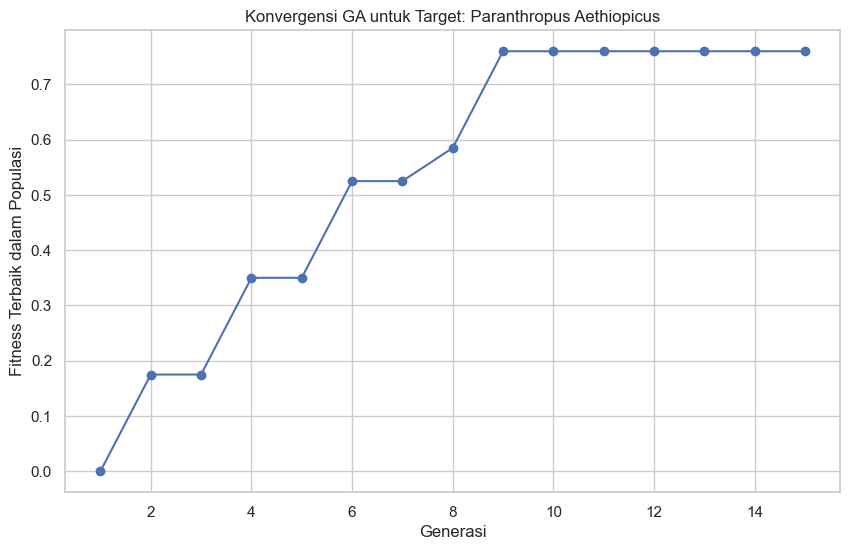

In [4]:
# Sel 4: Inisialisasi dan Menjalankan Algoritma Genetik

if RUN_GA:
    print("\n--- Menginisialisasi dan Menjalankan GA Evolution Simulator ---")
    
    # Buat instance dari kelas GA
    # Pastikan nama kelasnya benar (GeneticAlgorithmEvolutionSimulator atau yang Anda gunakan)
    # dan semua argumen __init__ sesuai.
    try:
        ga_simulator = GeneticAlgorithmFeatureSelection(
            original_df=evolution_df.copy(),
            label_col=LABEL_COL_IN_DATASET,
            all_original_feature_names=list(FEATURE_ORDER), # Sesuai dengan panjang kromosom
            numerical_cols_original=original_numerical_cols,
            categorical_cols_original=original_categorical_cols,
            population_size=ga_parameters["population_size"],
            num_generations=ga_parameters["num_generations"],
            crossover_prob=ga_parameters["crossover_prob"],
            mutation_prob=ga_parameters["mutation_prob"],
            num_features=NUM_FEATURES, # Dari chromosome_setup
            target_genus_specie_for_ga=target_species,
            initial_user_params_for_ga=processed_user_input_dict, # Input pengguna yang sudah diproses
            # fitness_params bisa diisi jika fungsi calculate_combined_fitness memerlukannya
            # atau jika Anda ingin mengatur bobot fitness dari sini.
            # Contoh: fitness_params = {'weight_target': 0.7, 'weight_user': 0.3}
            fitness_params = {} 
        )

        # Jalankan GA
        # Asumsi ga_simulator.run() mengembalikan:
        # best_chromosome_list, best_fitness, (mungkin None atau nama fitur), evolution_log_tuples
        best_chromosome, final_fitness, _, evolution_log = ga_simulator.run()

        print("\n--- Hasil Simulasi GA ---")
        print(f"Target Genus & Spesies: {target_species}")
        print(f"Fitness Terbaik Final: {final_fitness:.4f}")
        
        final_best_features_dict = {feature: best_chromosome[i] for i, feature in enumerate(FEATURE_ORDER)}
        print("Fitur Terbaik Final yang Dihasilkan GA:")
        for k,v in final_best_features_dict.items():
            print(f"  {k}: {v}")

        # Menampilkan Jalur Evolusi (beberapa generasi pertama dan terakhir)
        print("\n--- Jalur Evolusi (Contoh Individu Terbaik per Generasi) ---")
        num_to_show = 5 # Tampilkan beberapa generasi awal dan akhir
        if len(evolution_log) > 2 * num_to_show:
            log_to_display = evolution_log[:num_to_show] + evolution_log[-num_to_show:]
        else:
            log_to_display = evolution_log
            
        for gen_data in log_to_display:
            gen_num, fit_val, chromo_list = gen_data
            chromo_dict = {feature: chromo_list[i] for i, feature in enumerate(FEATURE_ORDER)}
            print(f"\nGenerasi: {gen_num}, Fitness: {fit_val:.4f}")
            # Tampilkan beberapa fitur kunci untuk melihat perubahan
            # print(f"  Time: {chromo_dict.get('Time', 'N/A'):.2f}, Cranial_Capacity: {chromo_dict.get('Cranial_Capacity', 'N/A'):.0f}, Height: {chromo_dict.get('Height', 'N/A'):.0f}, Diet: {chromo_dict.get('Diet', 'N/A')}")
            # Anda bisa menambahkan fitur lain yang ingin dipantau

        # Plotting konvergensi fitness
        if evolution_log:
            generations = [log[0] for log in evolution_log]
            fitness_values = [log[1] for log in evolution_log]
            plt.figure(figsize=(10, 6))
            plt.plot(generations, fitness_values, marker='o', linestyle='-')
            plt.title(f'Konvergensi GA untuk Target: {target_species}')
            plt.xlabel('Generasi')
            plt.ylabel('Fitness Terbaik dalam Populasi')
            plt.grid(True)
            plt.show()

    except Exception as e:
        print(f"Terjadi error saat menjalankan GA: {e}")
        import traceback
        traceback.print_exc()